In [21]:
import os
os.chdir(os.path.expanduser('~/FFF/'))
import fff
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import os
import pickle as pkl
matplotlib.rcParams.update({'font.size': 18})
import umap

In [22]:
model = fff.FreeFormInjectiveFlow.load_from_checkpoint(
    "lightning_logs/16class10_decoder/version_0/checkpoints/last.ckpt"
)

torch.Size([60000, 1, 16, 16])
cond_dim:  0
latent_dim:  10
[10, 512, 512, 10]
[10, 512, 512, 10]
[10, 512, 512, 10]
[10, 512, 512, 10]


In [23]:
from fff.model.utils import guess_image_shape
class Truncate(torch.nn.Module):
            def __init__(self):
                super(Truncate, self).__init__()
                enc_conv = list(
                    list(
                    list(
                    list(
                        model.children()
                    )[1].children()
                    )[0].children()
                    )[0].children()
                    )[0]
                enc_res = list(
                    list(
                    list(
                    list(
                    list(
                        model.children()
                    )[1].children()
                    )[1].children()
                    )[0].children()
                    )[0].children()
                    )[:]
                self.features = torch.nn.Sequential(
                    enc_conv
                )

            def cat_x_c(self, x, c):
                # Reshape as image, and concatenate conditioning as channel dimensions
                has_batch_dimension = len(x.shape) > 1
                if not has_batch_dimension:
                    x = x[None, :]
                    c = c[None, :]
                batch_size = x.shape[0]
                input_shape = guess_image_shape(model.data_dim)
                x_img = x.reshape(batch_size, *input_shape)
                c_img = c[:, :, None, None] * torch.ones(batch_size, model.cond_dim, *input_shape[1:], device=c.device)
                out = torch.cat([x_img, c_img], -3).reshape(batch_size, -1)
                if not has_batch_dimension:
                    out = out[0]
                return out
            
            def forward(self, x, c):
                x = self.features(self.cat_x_c(x,c))
                return x

Features = Truncate()

In [24]:
torch.set_grad_enabled(False)

In [35]:
df = pd.read_pickle("data/Mnist_Class")
# read targets and conditions from dataframe
train_data, train_targets = (
    torch.from_numpy(df["train_x"]),
    torch.from_numpy(df["train_y"]),
)

center = torch.mean(train_targets)
std = torch.std(train_targets)
print(train_targets[-100:-90])

tensor([[-0.0273, -0.9662,  0.0665,  0.5286,  0.4490, -1.3066,  2.6499, -1.3134,
         -1.7661, -1.2581],
        [-1.5925, -0.6659,  1.2724,  0.6118, -2.2520, -1.9463, -0.2872, -1.5747,
         -0.4130,  0.4552],
        [-0.8485,  1.7659,  1.6666,  0.6061, -1.2952, -1.7004, -0.3844, -0.6969,
         -1.1002, -1.5944],
        [ 1.9682, -1.9105,  0.6805, -0.2540, -0.9008, -1.2080,  0.0238,  0.2537,
         -1.1626, -0.5303],
        [-1.0322, -1.7611, -1.1646,  0.7506,  0.7912, -1.4274, -0.3672,  0.1774,
         -1.4233,  1.8404],
        [-1.0287, -1.9179, -0.3115,  1.9125, -1.4572, -0.0790,  0.0633, -0.7228,
         -2.0500, -0.2987],
        [-1.4685, -0.6625,  0.8164,  1.4249, -1.0169, -1.4376, -1.4863,  1.4888,
         -1.1803,  0.0195],
        [-1.0965, -1.2554,  3.0343,  1.1415, -0.6089, -1.7086, -0.9545, -0.7291,
         -1.6190, -0.8765],
        [-0.5601, -0.0200,  1.8235,  0.8638, -0.9471, -2.1312, -0.7350, -1.6919,
         -0.4450, -0.2834],
        [-0.1058, -

torch.Size([50000, 256])
encoding traindata...


/export/home/wjoran/miniconda3/envs/py11/lib/python3.11/site-packages/torch/nn/modules/module.py:1511: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


encoding valdata...
encoding testdata...


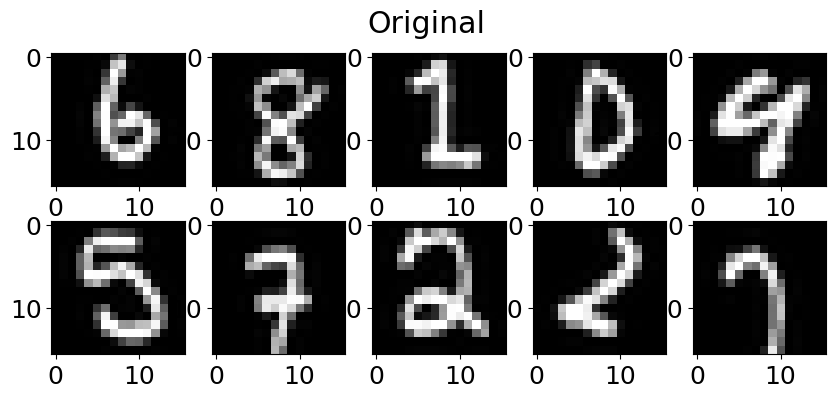

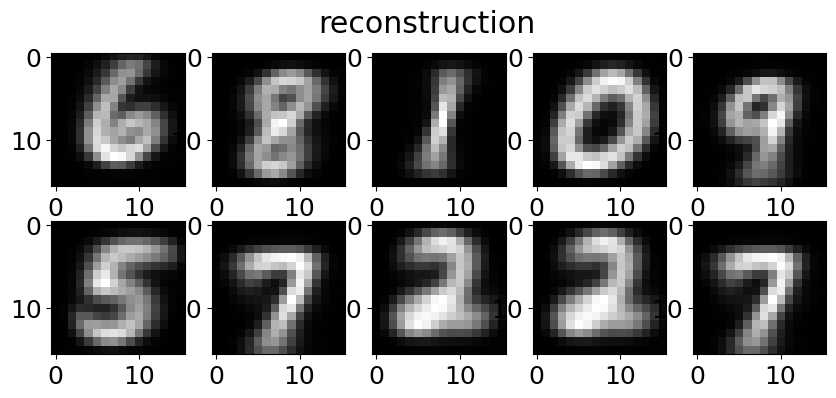

In [28]:
data = save_data(model, Features)

In [33]:
path = "data/"
fileName = path + 'Mnist_Class'
fileObject = open(fileName, 'wb')

pkl.dump(data, fileObject)
fileObject.close()

(10000,)


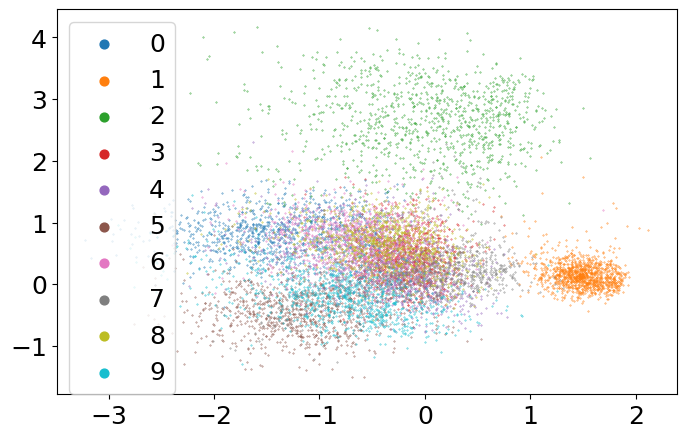

In [29]:
plt.figure(figsize=[8,5])
N = 10000
z_val = data["test_y"][-N:]
z_train = data["train_y"]
center = np.mean(z_train)
std = np.std(z_train)

#z_train = (z_train - center) / std
z_val = (z_val - center) / std
#z_test = (z_test - center) / std
y = np.argmax(data["test_l"][-N:],axis=1)
z0 = z_val[:,1]
z1 = z_val[:,2]
print(y.shape)
for i in range(10):
    z0i = z0[y==i]
    z1i = z1[y==i]
    plt.scatter(z0i,z1i, s=0.1, label=i)
plt.legend(markerscale=20.)

In [30]:
reducer = umap.UMAP()
embedding = reducer.fit_transform(z_val)
print(embedding.shape)

(10000, 2)


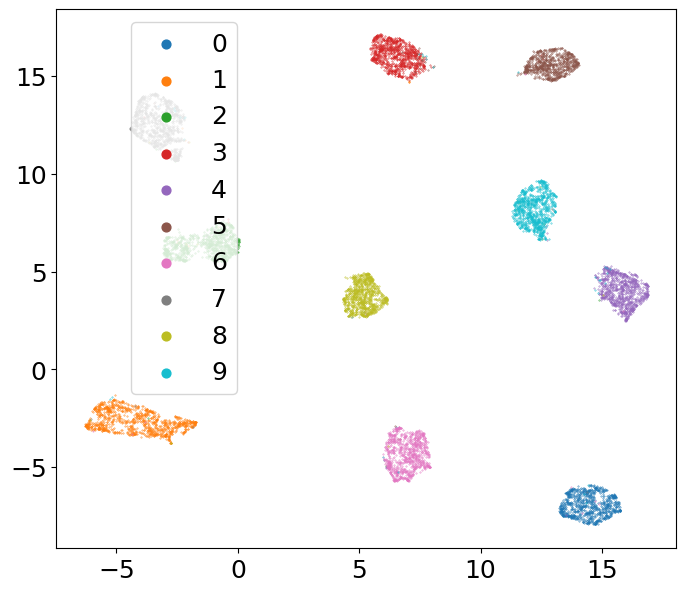

In [31]:
plt.figure(figsize=[8,7])
y = np.argmax(data["test_l"][-N:],axis=1)
for i in range(10):
    emb = embedding[y==i]
    plt.scatter(
        emb[:, 0],
        emb[:, 1],
        s=0.1, label=i
    )
plt.legend(markerscale=20.,loc='upper left',bbox_to_anchor=(0.1, 1.))
plt.savefig(f"plots/GTs/AE5/umap_logits.png")

In [27]:
def save_data(orig_model, feature_model):
    train_data = orig_model.train_data[:]
    
    Gen_samples = pd.read_pickle("data/MNIST/mnist16")
    Gen_samples = (Gen_samples - torch.mean(Gen_samples)) / torch.std(Gen_samples)
    #Gen_samples = Gen_samples * torch.std(train_samples) + torch.mean(train_samples)
    Gen_samples = Gen_samples * 0.3081 + 0.1307
    rand_perm = torch.randperm(Gen_samples.shape[0])
    Gen_samples = Gen_samples.reshape(-1,256)

    print(train_data[0].shape)
    #train_data_img = torch.cat([train_data[0], Gen_samples[rand_perm]], dim=0)
    #train_data_labels = torch.cat([train_data[1], torch.zeros([rand_perm.shape[0],10])], dim=0)
    #print(train_data_img.shape)
    #train_data = (train_data_img, train_data_labels)
    
    val_data = orig_model.val_data[:]
    test_data = orig_model.test_data[:]
    
    conditioned = orig_model.apply_conditions(train_data)
    train_samples = conditioned.x0
    c_t_ = conditioned.condition
    c_t = torch.empty((c_t_.shape[0], 0), device=c_t_.device)
    
    conditioned = orig_model.apply_conditions(val_data)
    val_samples = conditioned.x0
    c_v_ = conditioned.condition
    c_v = torch.empty((c_v_.shape[0], 0), device=c_v_.device)

    conditioned = orig_model.apply_conditions(test_data)
    test_samples = conditioned.x0
    c_test_ = conditioned.condition
    c_test = torch.empty((c_test_.shape[0], 0), device=c_test_.device)
    
    device = orig_model.device
    print("encoding traindata...")
    batch_size = orig_model.hparams.batch_size
    z_train = torch.cat([
        feature_model(batch.to(device), c_batch.to(device)).cpu()
        for batch, c_batch in zip(train_samples.split(batch_size), c_t.split(batch_size))
    ])
    label_train = torch.cat([
        orig_model.encode(batch.to(device), c_batch.to(device)).cpu()
        for batch, c_batch in zip(train_samples.split(batch_size), c_t.split(batch_size))
    ])
    print("encoding valdata...")
    z_val = torch.cat([
        feature_model.forward(batch.to(device), c_batch.to(device)).cpu()
        for batch, c_batch in zip(val_samples.split(batch_size), c_v.split(batch_size))
    ])
    print("encoding testdata...")
    z_test = torch.cat([
        feature_model.forward(batch.to(device), c_batch.to(device)).cpu()
        for batch, c_batch in zip(test_samples.split(batch_size), c_test.split(batch_size))
    ])
    
    reco = torch.cat([
        orig_model.decode(batch.to(device), c_batch.to(device)).cpu()
        for batch, c_batch in zip(label_train.split(batch_size), c_t.split(batch_size))
    ])
    orig = train_samples[-100:]
    reco = reco[-100:]
    fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(10, 4))
    for i in range(2):
        for j in range(5):
            axes[i][j].imshow(orig[i*5 +j].cpu().reshape(16, 16), cmap='gray')
    fig.suptitle("Original")
    fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(10, 4))
    for i in range(2):
        for j in range(5):
            axes[i][j].imshow(reco[i*5 +j].cpu().reshape(16, 16), cmap='gray')
    fig.suptitle("reconstruction")

    
    #print(z_train[:10]-train_targets[:10])
    """
    center = torch.mean(z_train)
    std = torch.std(z_train)

    z_train = (z_train - center) / std
    z_val = (z_val - center) / std
    z_test = (z_test - center) / std
    """
    

    data = {}
    
    data["train_x"] = train_samples.cpu().numpy()
    data["train_y"] = z_train.cpu().numpy()
    data["train_l"] = label_train.cpu().numpy()
    
    data["val_x"] = val_samples.cpu().numpy()
    data["val_y"] = z_val.cpu().numpy()
    data["val_l"] = c_v_.cpu().numpy()

    data["test_x"] = test_samples.cpu().numpy()
    data["test_y"] = z_test.cpu().numpy()
    data["test_l"] = c_test_.cpu().numpy()

    
    path = "data/"
    fileName = path + 'Mnist_Class'
    #fileObject = open(fileName, 'wb')
    
    #pkl.dump(data, fileObject)
    #fileObject.close()
    
    return data

In [19]:
from fff.evaluate.plots import all_conditions
def plot_mnist(rectangular_flow):
    data = {}
    train_batch = rectangular_flow.train_data[:]
    val_batch = rectangular_flow.test_data[:5000]

    conditioned = rectangular_flow.apply_conditions(train_batch)
    train_samples = conditioned.x0
    c_train = conditioned.condition
    
    conditioned = rectangular_flow.apply_conditions(val_batch)
    #print(val_batch[1][:10])
    c_val = conditioned.condition
    print(torch.argmax(c_val, dim=1)[:10])
    targets = torch.argmax(c_val, dim=1)
    val_samples = conditioned.x0

    c_val = torch.empty((c_val.shape[0], 0), device=c_val.device)
    
    device = rectangular_flow.device
    
    print("encoding...")
    batch_size = rectangular_flow.hparams.batch_size
    #print(batch_size)
    z_val = torch.cat([
        rectangular_flow.encode(batch.to(device), c_batch.to(device)).cpu()
        for batch, c_batch in zip(val_samples.split(batch_size), c_val.split(batch_size))
    ])
    fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(10, 4))
    for i in range(2):
        for j in range(5):
            axes[i][j].imshow(val_samples[i*5 +j].cpu().reshape(8, 8), cmap='gray')
    fig.suptitle("Original")
    """
    classes = np.arange(10)
    fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(14, 8))
    a = np.linspace(-5,5,100)
    for i in range(2):
        for j in range(5):
            axes[i][j].bar(classes, z_val[5*i+j])
    fig.suptitle("Classifier")
    fig.tight_layout()
    """

    accuracy = torch.sum(targets==torch.argmax(z_val,dim=1))/targets.shape[0]
    print(accuracy)
    

tensor([7, 2, 1, 0, 4, 1, 4, 9, 5, 9])
encoding...


/export/home/wjoran/miniconda3/envs/py11/lib/python3.11/site-packages/torch/nn/modules/module.py:1511: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


tensor(0.9802)


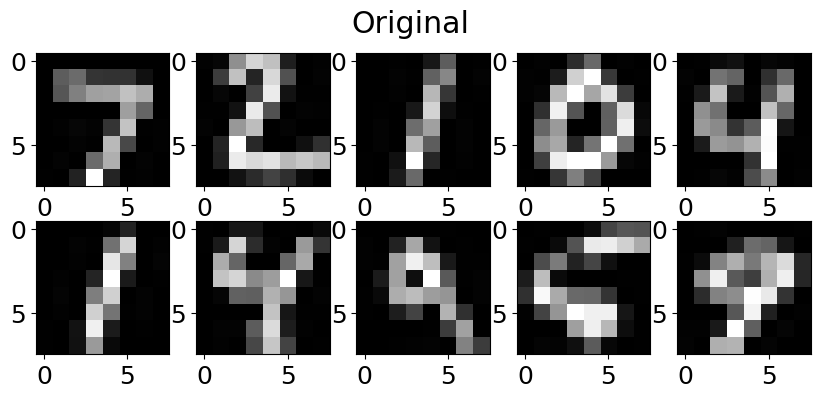

In [20]:
plot_mnist(model)

In [6]:
print(
    list(
    list(
        model.children()
    )[1].children()
    )
)

[ConvolutionalNeuralNetwork(
  (model): Sequential(
    (encoder): Sequential(
      (0): Unflatten(dim=-1, unflattened_size=(1, 16, 16))
      (1): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (2): ReLU()
      (3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (4): ReLU()
      (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (6): ReLU()
      (7): Flatten(start_dim=-3, end_dim=-1)
      (8): Linear(in_features=1024, out_features=32, bias=True)
    )
    (decoder): Sequential(
      (0): Linear(in_features=32, out_features=4096, bias=True)
      (1): Unflatten(dim=-1, unflattened_size=(256, 4, 4))
      (2): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (3): ReLU()
      (4): ConvTranspose2d(128, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
      (5): Sigmoid()
      (6): Flatten(start_dim=-3, end_dim=-1)
    )
  )
), ResNet(
  (model

In [1]:
print(
    list(
    list(
    list(
    list(
    list(
        model.children()
    )[1].children()
    )[1].children()
    )[0].children()
    )[0].children()
    )[:]
)

NameError: name 'model' is not defined